In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from  sklearn.model_selection import train_test_split, cross_val_score

from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [59]:
df = pd.read_csv('bank.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [60]:
df.shape

(11162, 17)

In [61]:
df.columns.values

array(['age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration',
       'campaign', 'pdays', 'previous', 'poutcome', 'deposit'],
      dtype=object)

In [62]:
df.columns = df.columns.str.replace(' ', '_')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [63]:
# To check for NA or missing values
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [64]:
# To show some statistics
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [65]:
# To get Customer Churn count
df['deposit'].value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

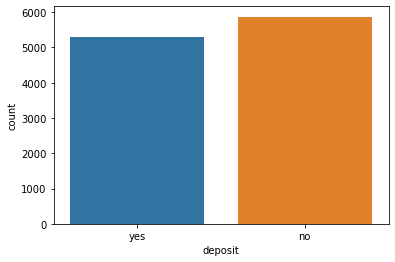

In [66]:
# Visualize the count of customer churn
sns.countplot(df['deposit'])

In [67]:
# To see the percentage of customers that are leaving
customersRetained = df['deposit'].value_counts()[1]
customersChurned = df['deposit'].value_counts()[0]

totalCustomers = customersRetained + customersChurned

print('Customers stayed in the company: ', (customersRetained / totalCustomers) * 100, '%')
print('Customers left with the company: ', (customersChurned / totalCustomers) * 100, '%')

Customers stayed in the company:  47.38398136534671 %
Customers left with the company:  52.61601863465329 %


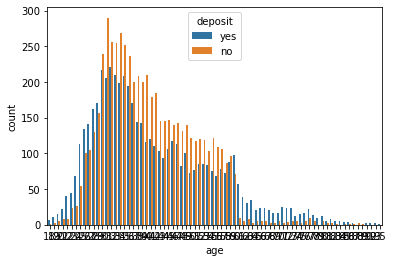

In [68]:
# Visualize the churn count for customer service calls
sns.countplot(x = 'age', hue = 'deposit', data = df)

In [69]:
# our target, 'y' variable:
y = df.deposit
# df of our features data 'X' - drop target
X = df.drop("deposit", axis=1)

In [70]:
# create dummy variables for categorical columns
X = pd.get_dummies(X, drop_first = True)

### Models

In [71]:
graph = []

In [72]:
def color(model_name):
    if (model_name == 'lr'):
        return 'cyan'
    elif (model_name == 'knn'):
        return 'blue'
    elif (model_name == 'rf'):
        return 'blue'
    elif (model_name == 'nb'):
        return 'green'
    elif (model_name == 'ada'):
        return 'yellow'
    elif (model_name == 'gbc'):
        return 'magenta'
    elif (model_name == 'proposed model'):
        return 'black'
    return 'red'

def plotModel(x, y, model_name):
    fpr, tpr, thresh = roc_curve(x, y, pos_label=1)
    graph.append([fpr, tpr, model_name])

In [73]:
def confusionMatrix(y_test, y_pred):
    matrix = confusion_matrix(y_test, y_pred)
    tp, fp, fn, tn = matrix[0][0], matrix[0][1], matrix[1][0], matrix[1][1]

    precision = (tp / (tp + fp))
    recall = (tp / (tp + fn))
    accuracy = ((tp + tn) / (tp + fp + fn + tn))

    return precision, recall, accuracy

def AUC(X_test, y_test, model, model_name):
    pred = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, pred[:, 1])
    plotModel(y_test, pred[:,1], model_name)
    return auc, 2*auc - 1

In [74]:
def Kmeans(X_train, X_test, y_train, y_test):
    n_clusters = len(np.unique(y_train))
    clf = KMeans(n_clusters = n_clusters, random_state=42)
    clf.fit(X_train)
    X_train['cluster'] = clf.labels_
    X_test['cluster'] = clf.predict(X_test)
    return X_train, X_test, y_train, y_test

def runModel(X_train, X_test, y_train, y_test, model, model_name):
    XT, xt, YT, yt = X_train, X_test, y_train, y_test
    model.fit(XT, YT)
    y_pred = model.predict(xt)
    precision, recall, accuracy = confusionMatrix(yt, y_pred)
    auc, gini = AUC(xt, yt, model, model_name)

    data = {
        'model': [model_name],
        'precision': [precision],
        'recall': [recall],
        'accuracy': [accuracy],
        'auc': [auc],
        'gini': [gini]
    }
    return pd.DataFrame(data)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=15)

In [76]:
result = pd.DataFrame()

### Without Clustering

In [77]:
logisticRegression = LogisticRegression(random_state=42, solver='lbfgs', max_iter=10000)
curr = runModel(X_train, X_test, y_train, y_test, logisticRegression, 'lr')
result = result.append(curr, ignore_index = True)

/Users/reetpalbhaati/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


In [78]:
knn = KNeighborsClassifier(n_neighbors=5)
curr = runModel(X_train, X_test, y_train, y_test, knn, 'knn')
result = result.append(curr, ignore_index = True)

/Users/reetpalbhaati/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


In [79]:
# instantiate random forest classifier object
randomForest = RandomForestClassifier(n_estimators=100, max_depth= 5)
curr = runModel(X_train, X_test, y_train, y_test, randomForest, 'rf')
result = result.append(curr, ignore_index = True)

/Users/reetpalbhaati/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


In [80]:
naiveBayes = GaussianNB()
curr = runModel(X_train, X_test, y_train, y_test, naiveBayes, 'nb')
result = result.append(curr, ignore_index = True)

/Users/reetpalbhaati/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


In [81]:
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
curr = runModel(X_train, X_test, y_train, y_test, ada, 'ada')
result = result.append(curr, ignore_index = True)

/Users/reetpalbhaati/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


In [82]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
curr = runModel(X_train, X_test, y_train, y_test, gbc, 'gbc')
result = result.append(curr, ignore_index = True)

/Users/reetpalbhaati/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


In [83]:
print(result)

  model  precision    recall  accuracy       auc      gini
0    lr   0.854095  0.822944  0.828377  0.901375  0.802749
1   knn   0.772195  0.743046  0.742386  0.797075  0.594149
2    rf   0.824501  0.826777  0.818703  0.899445  0.798890
3    nb   0.874054  0.680600  0.720889  0.817008  0.634016
4   ada   0.858913  0.829787  0.834826  0.899685  0.799369
5   gbc   0.856848  0.838384  0.839484  0.905564  0.811128


### With clustering

In [84]:
X_train, X_test, y_train, y_test = Kmeans(X_train, X_test, y_train, y_test)
X_train

<ipython-input-74-d23a5aab0259>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['cluster'] = clf.labels_
<ipython-input-74-d23a5aab0259>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['cluster'] = clf.predict(X_test)


,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,cluster
3013,72,3856,10,582,4,115,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7568,31,1575,12,178,4,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3771,23,1807,27,606,1,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6596,53,100,13,205,4,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10878,50,383,2,382,2,-1,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6528,31,368,5,414,5,361,3,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2693,57,3109,15,107,2,105,2,1,0,0,...,0,0,0,0,0,1,0,1,0,0
8076,34,31,9,53,3,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3829,57,470,5,480,3,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [85]:
# instantiate random forest classifier object
ensemble = RandomForestClassifier(n_estimators=110, max_depth = 30)
curr = runModel(X_train, X_test, y_train, y_test, ensemble, 'proposed model')
result = result.append(curr, ignore_index = True)

/Users/reetpalbhaati/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


In [86]:
result

,model,precision,recall,accuracy,auc,gini
0,lr,0.854095,0.822944,0.828377,0.901375,0.802749
1,knn,0.772195,0.743046,0.742386,0.797075,0.594149
2,rf,0.824501,0.826777,0.818703,0.899445,0.798890
3,nb,0.874054,0.680600,0.720889,0.817008,0.634016
4,ada,0.858913,0.829787,0.834826,0.899685,0.799369
5,gbc,0.856848,0.838384,0.839484,0.905564,0.811128
6,proposed model,0.823125,0.882657,0.850949,0.921272,0.842545
